In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D,Dropout, Add, AveragePooling2D
from tensorflow.keras.layers import RandomCrop, RandomFlip, RandomRotation, RandomContrast
from keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Loader

In [2]:
def load_cifar100():
    # Load in the data 
    cifar100 = tf.keras.datasets.cifar100 
      
    # Distribute it to train and test set
    (x_train, y_train), (x_val, y_val) = cifar100.load_data() 
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape) 
    
    #scale the data
    x_train = x_train/255
    x_val = x_val/255
    
    # #splitting dev set to test and validation
    indices = np.arange(x_val.shape[0])
    np.random.shuffle(indices)
    
    x_val = x_val[indices]
    y_val = y_val[indices]
    
    
    test_size = int(x_val.shape[0] * 0.7)
    print(test_size)
    x_test = x_val[:test_size]
    y_test = y_val[:test_size]
    return (x_train,y_train),(x_val, y_val)

def load_from_directory(filename):
    data = tf.keras.utils.image_dataset_from_directory(filename,batch_size=32,image_size=(128,128))
    
    
    return data
    
def split_dir_dataset(data):
    data = data.map(lambda x,y: (x/255,y))
    train_size = int(len(data)*.8)
    val_size = int(len(data)*.1)
    test_size = int(len(data)*.1)

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size+val_size).take(test_size)
    print(f'training shape: {train.as_numpy_iterator().next()[0].shape}')
    return train,val,test



In [3]:
# (x_train, y_train), (x_val, y_val) = load_cifar100()

data = load_from_directory(r'C:\Users\warfa\Desktop\Python\AI\BingoAI\data')
train, val, test = split_dir_dataset(data)

Found 20837 files belonging to 121 classes.
training shape: (32, 128, 128, 3)


## neccessary functions

In [4]:
def show_samples(data, labels):
    plt.subplots(figsize=(10, 10)) 
    for i in range(12): 
        plt.subplot(3, 4, i+1) 
        k = np.random.randint(0, data.shape[0]) 
        plt.title(labels[k]) 
        plt.imshow(data[k]) 
    plt.tight_layout() 
    plt.show() 
    
def show_samples_dataset(data):
    class_names = data.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
def show_results(hist,mode='acc'):
    if mode == 'acc' or mode == 'accuracy':
        mode = 'accuracy'
        val_mode = 'val_accuracy'
    elif mode == 'loss':
        mode = "loss"
        val_mode = "val_loss"
    
    fig = plt.figure()
    plt.plot(hist.history[mode], color='teal', label=mode)
    plt.plot(hist.history[val_mode], color='orange', label=val_mode)
    fig.suptitle(mode, fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

def prediction_test(model,x_val,y_val):
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = y_val
    return y_true,y_pred



def prediction_dir_dataset(model,test):
    y_true = []
    y_pred = []
    for batch in test.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        yhat = np.argmax(yhat,axis=1)
        y_true.append(y)
        y_pred.append(yhat)
    y_true = np.array(y_true)
    y_true = y_true.reshape(-1)
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    return y_true,y_pred

def scores(y_true,y_pred,show_confusion_matrix=True):
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    if show_confusion_matrix == True:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    print(f"precision weighted: {'{:.3f}'.format(precision_weighted)}\nprecision micro: {precision_micro} ")
    print(f'recall weighted: {recall_weighted}\nrecall micro: {recall_micro} ')
    print(f'f1 weighted: {"{:.3f}".format(f1_weighted)}\nf1 micro: {f1_micro} ')

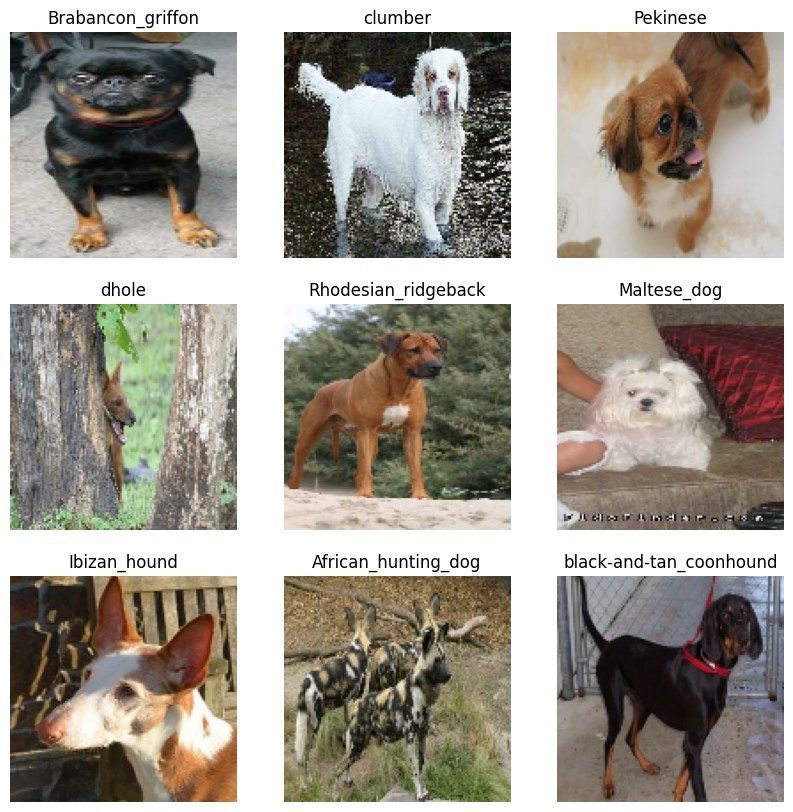

In [5]:
# show_samples(x_val,y_val)
show_samples_dataset(data)

# Model

## The identity block
standart block for the same dimension input-output 

In [6]:
def identity_block(X,f,filters,stage,block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    F1,F2,F3 = filters


    X_shortcut = X

    X = Conv2D(filters=F1,kernel_size=1, strides=1,padding='valid',name=conv_name_base+'2a')(X)
    X = BatchNormalization(axis=3,name = bn_name_base+"2a")(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=(f,f), strides=1,padding='same',name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3,name = bn_name_base+"2b")(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=F3,kernel_size=1, strides=1,padding='valid',name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3,name = bn_name_base+"2c")(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## convolutional block
used for different input and output dimensions

In [7]:
def conv_block(X,f,filters,stage,block,s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X


    X = Conv2D(filters=F1,kernel_size=1, strides=s,padding='valid',name=conv_name_base+'2a')(X)
    X = BatchNormalization(axis=3,name = bn_name_base+"2a")(X)
    X = Activation('relu')(X)


    X = Conv2D(filters=F2,kernel_size=f, strides=1,padding='same',name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3,name = bn_name_base+"2b")(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3,kernel_size=1, strides=1,padding='valid',name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3,name = bn_name_base+"2c")(X)


    #shortcut path
    X_shortcut = Conv2D(F3, 1, strides=s, padding='valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X
    

In [8]:
def data_augment(X):
    seed = 4
    X = RandomCrop(height=96,width=96,seed=seed)(X)
    X = RandomFlip(mode="horizontal_and_vertical",seed=seed)(X)
    X = RandomRotation(factor=0.2)(X)
    X = RandomContrast(0.4,seed=seed)(X)
    return X
    

# Building ResNet50


In [10]:
def ResNet50(input_shape=(64,64,3), num_classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    
    """
    
    X_input = Input(input_shape)
    

    X = ZeroPadding2D((3,3))(X_input)
    X = data_augment(X)
    #first stage
    X = Conv2D(64,(7,7),strides=(2,2),name="conv1")(X)
    X = BatchNormalization(axis = 3, name = "bn_conv1")(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    

    #stage 2
    f = 3
    stage = 2
    stage2_filters = [64,64,256]

    X = conv_block(X, f, stage2_filters, stage, block = 'a', s = 1)
    X = identity_block(X, f, stage2_filters, stage, block = 'b')
    X = identity_block(X, f, stage2_filters, stage, block = 'c')
    X = Dropout(0.2)(X)

    #stage 3
    stage = 3
    stage3_filters = [128,128,512]

    X = conv_block(X, f, stage3_filters, stage, block = 'a')
    X = identity_block(X, f, stage3_filters, stage, block = 'b')
    X = identity_block(X, f, stage3_filters, stage, block = 'c')
    X = identity_block(X, f, stage3_filters, stage, block = 'd')
    X = Dropout(0.2)(X)

    #stage 4
    stage = 4
    stage4_filters = [256,256,1024]

    X = conv_block(X,f,stage4_filters,stage, block = 'a')
    X = identity_block(X, f, stage4_filters, stage, block = 'b')
    X = identity_block(X, f, stage4_filters, stage, block = 'c')
    X = identity_block(X, f, stage4_filters, stage, block = 'd')
    X = identity_block(X, f, stage4_filters, stage, block = 'e')
    X = identity_block(X, f, stage4_filters, stage, block = 'f')
    X = Dropout(0.2)(X)

    #stage 5
    stage = 5
    stage5_filters = [512,512,2048]
    
    
    X = conv_block(X, f, stage5_filters, stage, block = 'a')
    X = identity_block(X, f, stage5_filters, stage, block = 'b')
    X = identity_block(X, f, stage5_filters, stage, block = 'c')

    #Average Pooling
    X = AveragePooling2D((2,2), name = 'avg_pool')(X)

    #output layer
    X = Flatten()(X)
    X = Dropout(0.3)(X)
    X = Dense(num_classes, activation='softmax', name = f'softmax{num_classes}')(X)

    model = Model(inputs = X_input, outputs = X, name = "ResNet50")

    return model

In [20]:
dataset_name = 'dogs'

if dataset_name == 'cifar':
    class_count = y_train.max() + 1
    input_shape = x_train[0].shape
    BATCH_SIZE = 32
    
else:
    class_count = len(data.class_names)
    input_shape = train.as_numpy_iterator().next()[0][0].shape
    
EPOCHS = 40
VAL_FREQ = 6
print(f'number of classes: {class_count} ')
print(f"input shape : {input_shape}")

number of classes: 121 
input shape : (128, 128, 3)


In [21]:
model = ResNet50(input_shape,num_classes=class_count)

In [22]:
model.compile( 
	loss=tf.losses.SparseCategoricalCrossentropy(), 
	optimizer='adam',
	metrics=['accuracy'] ,
) 

callback = EarlyStopping(monitor='val_loss',patience=5,verbose=1)


In [23]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
random_crop_2 (RandomCrop)      (None, 96, 96, 3)    0           zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
random_flip_2 (RandomFlip)      (None, 96, 96, 3)    0           random_crop_2[0][0]              
___________________________________________________________________________________________

In [46]:
EPOCHS = 25

In [47]:
if dataset_name == 'cifar':
    hist = model.fit(x_train,
                     y_train,
                     epochs = EPOCHS,
                     batch_size = BATCH_SIZE,
                     validation_data=(x_val,y_val),
                     callbacks = [callback],
                     validation_freq=VAL_FREQ
                     )
else:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    train = train.cache()
    train = train.prefetch(buffer_size=AUTOTUNE)

    hist = model.fit(train,
                     epochs = EPOCHS,
                     validation_data=val,
                     callbacks = [callback],
                     validation_freq=VAL_FREQ)

Epoch 1/25
521/521 [==============================] - 54s 103ms/step - loss: 2.8438 - accuracy: 0.2663
Epoch 2/25
521/521 [==============================] - 54s 104ms/step - loss: 2.8221 - accuracy: 0.2660
Epoch 3/25
521/521 [==============================] - 53s 102ms/step - loss: 2.7684 - accuracy: 0.2799
Epoch 4/25
521/521 [==============================] - 53s 102ms/step - loss: 2.7310 - accuracy: 0.2847
Epoch 5/25
521/521 [==============================] - 53s 103ms/step - loss: 2.7295 - accuracy: 0.2871
Epoch 6/25
521/521 [==============================] - 69s 133ms/step - loss: 2.6870 - accuracy: 0.2943 - val_loss: 4.0433 - val_accuracy: 0.1601
Epoch 7/25
521/521 [==============================] - 54s 103ms/step - loss: 2.6396 - accuracy: 0.2999
Epoch 8/25
521/521 [==============================] - 53s 103ms/step - loss: 2.5974 - accuracy: 0.3099
Epoch 9/25
521/521 [==============================] - 53s 103ms/step - loss: 2.5792 - accuracy: 0.3174
Epoch 10/25
521/521 [==========

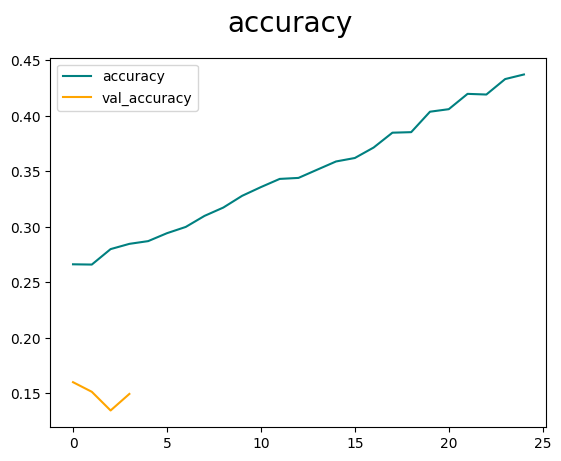

In [49]:
show_results(hist,mode='acc')

C:\Users\warfa\.conda\envs\AI\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


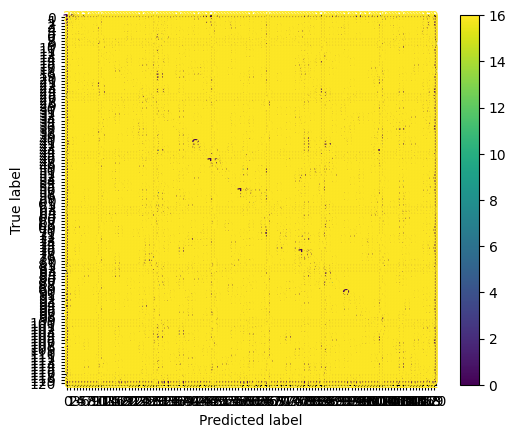

precision weighted: 0.189
precision micro: 0.13701923076923078 
recall weighted: 0.13701923076923078
recall micro: 0.13701923076923078 
f1 weighted: 0.127
f1 micro: 0.13701923076923078 


In [50]:

y_true, y_pred = prediction_dir_dataset(model,test)

scores(y_true,y_pred)

# Pipeline

In [58]:

def predict_breed(image_path,show=True):
    img = cv2.imread(image_path)
    resize = tf.image.resize(img, (128,128))
    if show:
        plt.imshow(resize.numpy().astype(int))
        plt.show()
    yhat = model.predict(np.expand_dims(resize/255, 0))
    yhat = yhat.argmax()
    print(f'predicted breed is: {data.class_names[yhat]}')


In [60]:
predict_breed(r'C:\Users\warfa\Desktop\Python\AI\BingoAI\data\bingo\\PXL_20230806_160600958.jpg',show=False)

predicted breed is: bingo
